In [4]:
pip install protobuf==3.20.1

     ---------------------------------------- 0.0/904.1 kB ? eta -:--:--
     ---------------------------------------- 10.2/904.1 kB ? eta -:--:--
     - ----------------------------------- 41.0/904.1 kB 495.5 kB/s eta 0:00:02
     ------- ------------------------------ 174.1/904.1 kB 1.5 MB/s eta 0:00:01
     -------------- ----------------------- 337.9/904.1 kB 2.1 MB/s eta 0:00:01
     --------------------- ---------------- 522.2/904.1 kB 2.5 MB/s eta 0:00:01
     ----------------------------- -------- 696.3/904.1 kB 2.7 MB/s eta 0:00:01
     ------------------------------------ - 860.2/904.1 kB 2.9 MB/s eta 0:00:01
     -------------------------------------- 904.1/904.1 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.0
    Uninstalling protobuf-4.25.0:
      Successfully uninstalled protobuf-4.25.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import mlflow



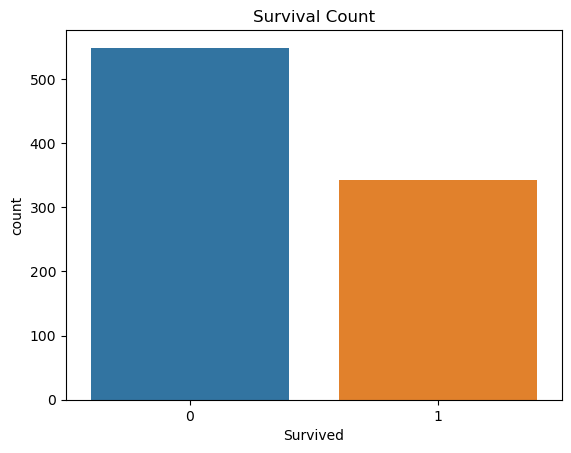

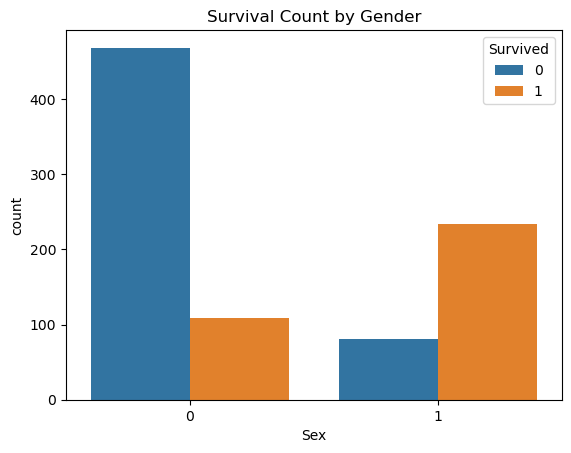

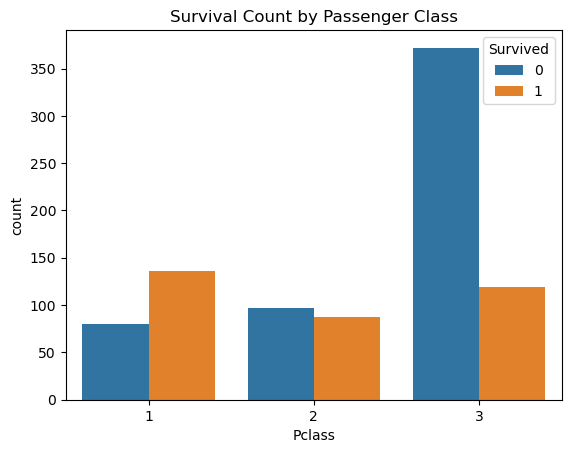

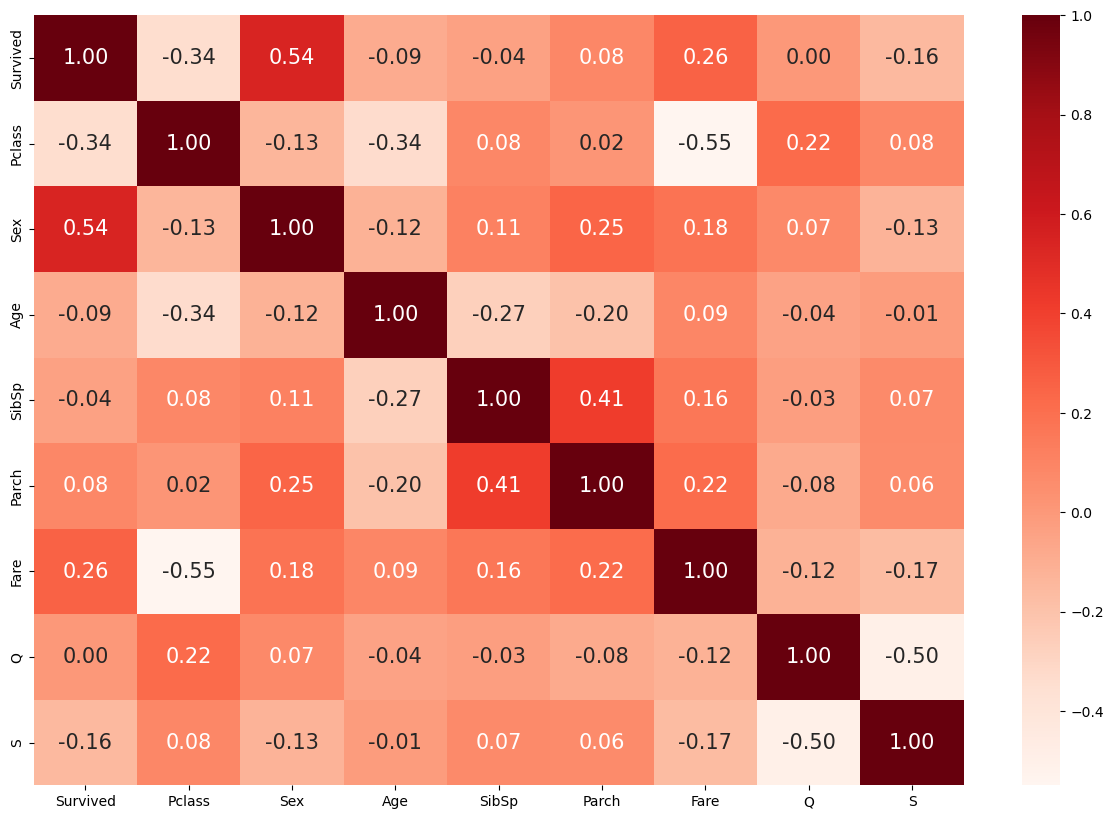

In [3]:
# Load the Titanic dataset
titanic = pd.read_csv('Titanic+Data+Set.csv')
df = titanic.copy()

# Clean the dataset
df.drop(['Cabin'], axis=1, inplace=True)

def filling_age(name_age): 
    name = name_age[0]
    age = name_age[1]
    if pd.isnull(age):
        if 'Mr.' in name:
            return mean_age_mr
        if 'Mrs.' in name:
            return mean_age_mrs
        if 'Miss.' in name:
            return mean_age_miss
        if 'Master.' in name:
            return mean_age_master
        if 'Dr.' in name:
            return mean_age_master
        if 'Ms.' in name:
            return mean_age_miss
    else:
        return age

mean_age_miss = round(df[df["Name"].str.contains('Miss.', na=False)]['Age'].mean())
mean_age_mrs = round(df[df["Name"].str.contains('Mrs.', na=False)]['Age'].mean())
mean_age_mr = round(df[df["Name"].str.contains('Mr.', na=False)]['Age'].mean())
mean_age_master = round(df[df["Name"].str.contains('Master.', na=False)]['Age'].mean())

df['Age'] = df[['Name', 'Age']].apply(filling_age, axis=1)

df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# Cleaned data
df_cat = df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Survived']]
df_cat.head()

# Map categorical values
categories = {"female": 1, "male": 0}
df['Sex'] = df['Sex'].map(categories)

new_df = pd.concat([df, pd.get_dummies(df['Embarked'], drop_first=True)], axis=1)
new_df.drop(['Embarked'], axis=1, inplace=True)

# Exploratory Data Analysis (EDA)
sns.countplot(x='Survived', data=new_df)
plt.title('Survival Count')
plt.show()

sns.countplot(x='Sex', hue='Survived', data=new_df)
plt.title('Survival Count by Gender')
plt.show()

sns.countplot(x='Pclass', hue='Survived', data=new_df)
plt.title('Survival Count by Passenger Class')
plt.show()

corr = new_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr, cbar=True, fmt='.2f', annot=True, annot_kws={'size': 15}, cmap='Reds')
plt.show()

# Remove outliers
q1 = new_df['Fare'].quantile(0.25)
q3 = new_df['Fare'].quantile(0.75)
iqr = q3 - q1
lower_range = q1 - 1.5 * iqr
upper_range = q3 + 1.5 * iqr
outlier_indices = new_df[(new_df['Fare'] < lower_range) | (new_df['Fare'] > upper_range)].index
cleaned_df = new_df.drop(outlier_indices)



In [4]:
# Split the dataset into training and testing sets
X = cleaned_df.drop('Survived', axis=1)
y = cleaned_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate the model
train_score = rf.score(X_train_scaled, y_train)
test_score = rf.score(X_test_scaled, y_test)

print('Training score: ', train_score)
print('Testing score: ', test_score)
mlflow.end_run()



Training score:  0.985239852398524
Testing score:  0.7811158798283262


In [5]:
# Start mlflow run
mlflow.start_run()

# Set hyperparameters
n_estimators = 100  # Number of estimators for the random forest
mlflow.end_run()

# Train the random forest classifier with MLflow logging
with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("n_estimators", n_estimators)
    
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=31)
    rf.fit(X_train_scaled, y_train)

    # Evaluate the model
    train_score = rf.score(X_train_scaled, y_train)
    test_score = rf.score(X_test_scaled, y_test)

    # Log evaluation metrics
    mlflow.log_metric("train_score", train_score)
    mlflow.log_metric("test_score", test_score)

# End mlflow run
mlflow.end_run()
print("end")
print('Training score: ', train_score)
print('Testing score: ', test_score)

# Make predictions 
test_predictions = rf.predict(X_test_scaled)

# Display the predictions
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
print(predictions_df.head())


end
Training score:  0.985239852398524
Testing score:  0.7811158798283262
     Actual  Predicted
493       0          0
821       1          0
381       1          1
881       0          0
420       0          0
